In [21]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --quiet
!pip install shuttle --quiet

In [22]:
project_name = 'cifar100-transfer-learning-resnet50'

In [23]:
# lets import all required libraries

import os,copy
import numpy as np
import tarfile
import shuttle
import torch.nn as nn
import time
from torchvision.datasets.utils import download_url
from torchvision.transforms import transforms
import torchvision.datasets as datasets
import torchvision
import opendatasets as od
import torch
import shuttle
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
# download data, Now I refer dataset from Kaggle
dataset_url = 'https://www.kaggle.com/minbavel/cifar-100-images'
od.download(dataset_url)

  0%|          | 0.00/140M [00:00<?, ?B/s]

100%|██████████| 140M/140M [00:01<00:00, 88.4MB/s]


In [25]:
data_dir = './cifar-100-images/CIFAR100/TRAIN'

print("Number of categories in CIFAR100 are {}".format(len(os.listdir(data_dir))))

Number of categories in CIFAR100 are 100


In [26]:
# lets see number of files in each category
# for folder in sorted(os.listdir(data_dir)):
#   path = data_dir+'/'+folder
#   print("Number of files in {} category are {}".format(folder,len(os.listdir(path))))

In [27]:
# As we have around 50000 images across 100 categories, lets keep 20% images, i.e 10000 images to validation
# this creates all required folders, such as Val and their subfolders
val_path = './cifar-100-images/CIFAR100/VAL'
source_dir = './cifar-100-images/CIFAR100/TRAIN'

os.mkdir(val_path)

for i in sorted(os.listdir(source_dir)):
  path = val_path+'/'+i
  os.mkdir(path)

FileExistsError: ignored

In [28]:
# This code copies random sample images from training folder to validation folder, it copies 100 such random images.
for folder in sorted(os.listdir(source_dir)):
  dest_path = val_path+'/'+folder
  source_path = source_dir+'/'+folder

  source_files = os.listdir(source_path)
  randint = sorted(random.sample(range(500), 100))
  # print("Random Integers \n",randint)
  for file in randint:
    source_file_name = source_path+'/'+source_files[file]
    dest_file_name = dest_path+'/'+source_files[file]
    os.rename(source_file_name,dest_file_name)

In [29]:
print("Number of files in Train folder are {}".
format(sum([len(os.listdir(data_dir+'/'+x)) for x in os.listdir(data_dir)])))

Number of files in Train folder are 40000


In [30]:
print("Number of files in Validation folder are {}".
format(sum([len(os.listdir(val_path+'/'+x)) for x in os.listdir(val_path)])))

Number of files in Validation folder are 17979


In [ ]:
# # we need to normalize the images, so we find mean and standard deviation for the images,
# # https://www.youtube.com/watch?v=y6IEcEBRZks
# # https://math.stackexchange.com/questions/3026285/why-does-operatornamevarx-ex2-ex2
# # VAR[X] = E[X**2] - E[X]**2
# def get_mean_std(loader):
#   channels_sum, channels_squared_sum, num_batches = 0, 0, 0

#   for data, _ in loader:
#     channels_sum += torch.mean(data, dim=[0,2,3])
#     channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#     num_batches += 1
  
#   mean = channels_sum / num_batches 
#   std = (channels_squared_sum / num_batches  - mean **2)**.5

#   return mean, std

# train_dl_for_mean_std = torch.utils.data.DataLoader(cifar100,batch_size=128,shuffle=True,num_workers=4, pin_memory=True)
# stats=get_mean_std(train_dl_for_mean_std)
# stats

# stats = ((0.5071, 0.4866, 0.4409), (0.2673, 0.2564, 0.2762))

data transforms helps model to become more generalized, lets apply transforms, Also As images might be of different sizes, keeping them in one size.

In [31]:
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4866, 0.4409], [0.2673, 0.2564, 0.2762])
    ]),
    'VAL': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4866, 0.4409], [0.2673, 0.2564, 0.2762])
    ]),
}

Creating torch datasets, along with data loaders.

In [32]:
data_dir = './cifar-100-images/CIFAR100/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['TRAIN', 'VAL']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['TRAIN', 'VAL']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'VAL']}
class_names = image_datasets['TRAIN'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

writing helper function to display a sample of images.

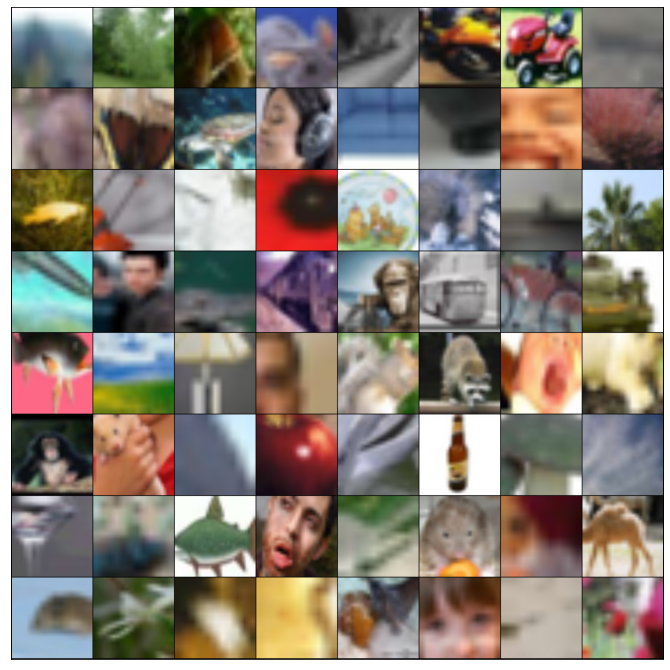

In [33]:
inputs, classes = next(iter(dataloaders['TRAIN']))


def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means



fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
denorm_images = denormalize(inputs, [0.5071, 0.4866, 0.4409],[0.2673, 0.2564, 0.2762])
ax.imshow(torchvision.utils.make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))

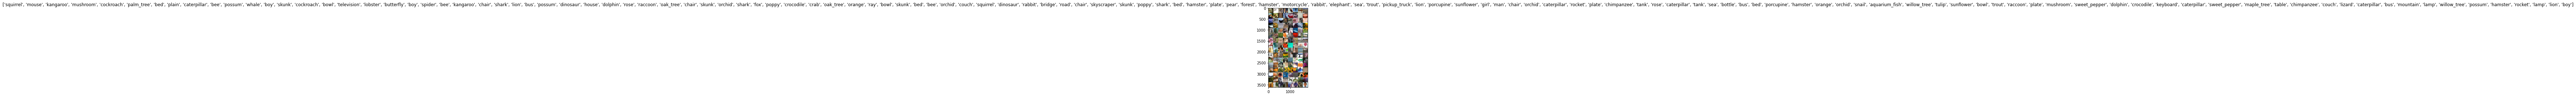

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4866, 0.4409])
    std = np.array([0.2673, 0.2564, 0.2762])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['TRAIN']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=8)

imshow(out, title=[class_names[x] for x in classes])

Helper function to train the model, 

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN', 'VAL']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TRAIN':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'VAL' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [36]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['VAL']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

As we applying Transfer learning, There are two ways to do transfer learning. 

**1. extracting the feature vectors from pretrained model**: Here we freeze the weights for all of the network except for final dense/fully connected layer. The final fully connected layer replaced with new one with random weights, only this particular layer gets trained.  

**2. Finetuning the model**: Here we initialize the training network, and we change dense layer parameters, and use same architecture, and train them. Rest is as usual.

lets try with first way, freeze the network and weights except for last layer.

In [37]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
TRAIN Loss: 4.3634 Acc: 0.0880
VAL Loss: 3.9832 Acc: 0.2242

Epoch 1/24
----------


In [ ]:
model_ft = torchvision.models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

In [ ]:
jovian.commit(project=project_name)

We did see that with SGD optimizer, model is getting stuck at saddle points, we can try with Adam optimizer and see how does it work.

We can go with fine training the model, by freezing the layers.

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

weight_decay = 1e-4
max_lr = 0.01
epochs = 25
optimizer_conv = torch.optim.Adam(model_conv.fc.parameters(), max_lr, weight_decay = weight_decay)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_conv, max_lr, epochs=epochs, 
                                                       steps_per_epoch=len(dataloaders['TRAIN']))
